# AIRLINE LOYALTY PROGRAM

# Cargar las librerías

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans

# Cargar los datos

In [45]:
customers = pd.read_csv("Customer Loyalty History.csv")
flight = pd.read_csv("Customer Flight Activity.csv")

In [46]:
customers.shape

(16737, 16)

In [47]:
customers.head(3)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0


In [48]:
flight.shape

(392936, 8)

In [49]:
flight.head(3)

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100590,2018,6,12,15276,22914.0,0,0
1,100590,2018,7,12,9168,13752.0,0,0
2,100590,2018,5,4,6504,9756.0,0,0


# ANÁLISIS EXPLORATORIO

### Tabla Flight

#### Nº de vuelos por fechas

In [53]:
flight['Flight Date'] = pd.to_datetime(flight['Year'].astype(str) + '-' + flight['Month'].astype(str) + '-01', format='%Y-%m-%d')

In [54]:
flight = flight.sort_values(by=['Loyalty Number', 'Flight Date']).reset_index(drop=True)

Text(0, 0.5, 'Total Flights')

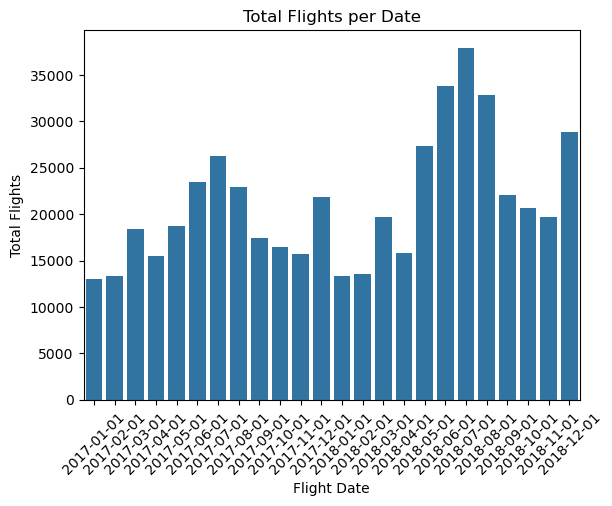

In [55]:
flight_summary = flight.groupby("Flight Date")["Total Flights"].sum().reset_index()

# Crear el gráfico de barras
sns.barplot(data=flight_summary, x="Flight Date", y="Total Flights")

# Personalizar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para que se lean mejor
plt.title("Total Flights per Date")
plt.xlabel("Flight Date")
plt.ylabel("Total Flights")

Los datos recogidos pertenecen a 2017 y 2018, en 2018 se realizó una campaña promocional que dió resultado aumentando el número de vuelos respecto a 2017.

<Axes: xlabel='Month', ylabel='Total Flights'>

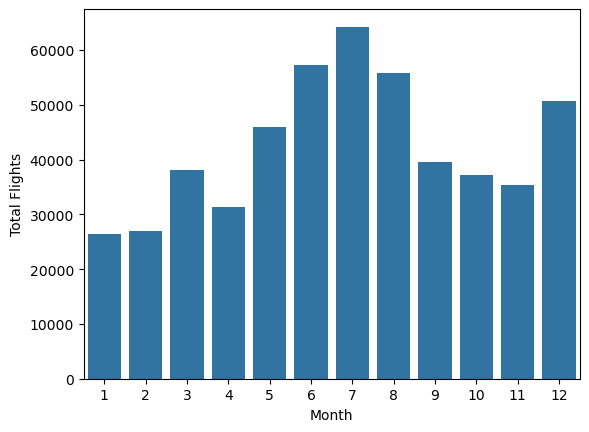

In [57]:
flight_summary2 = flight.groupby("Month")["Total Flights"].sum().reset_index()
sns.barplot(data=flight_summary2, x="Month", y="Total Flights")

También se observa una tendencia de los viajeros que aumenta en los meses de verano y navidades.

#### Relación de distancia y puntos acumulados
Aproximadamente 1 milla corresponde a 1 punto acumulado del programa de membresía.

In [60]:
flight[["Points Accumulated", "Distance"]].corr()

,Points Accumulated,Distance
Points Accumulated,1.000000,0.977671
Distance,0.977671,1.000000


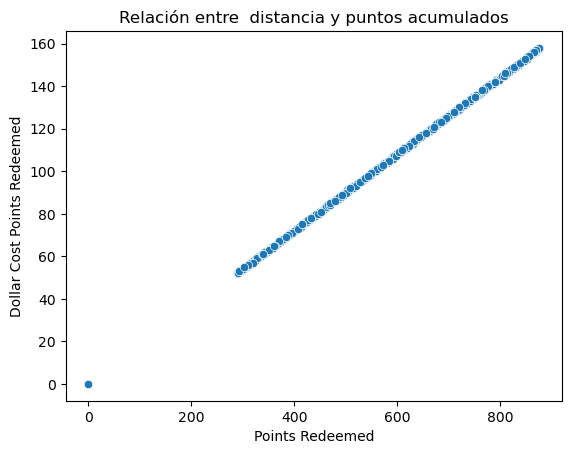

In [61]:
sns.scatterplot(data=flight, x='Points Redeemed', y='Dollar Cost Points Redeemed')
plt.title("Relación entre  distancia y puntos acumulados")
plt.show()

In [62]:
flight["Distance"].sum()/flight["Points Accumulated"].sum()

0.957708507804057

#### Relación de puntos canjeados y dólares
Aproximadamente 5.55 puntos corresponden con 1 dólar.

In [64]:
flight[["Points Redeemed", "Dollar Cost Points Redeemed"]].corr()

,Points Redeemed,Dollar Cost Points Redeemed
Points Redeemed,1.000000,0.999995
Dollar Cost Points Redeemed,0.999995,1.000000


# LIMPIEZA DE DATOS

## Tabla Customers
En la tabla tenemos información personal sobre cada uno de los clientes apuntados en el programa de membresía.

### Datos nulos
Rellenamos los datos de salario porque representan el 25% de los datos y los de las fechas los rellenamos con 0 porque nos serán útiles a la hora de trabajar con fechas.

In [68]:
customers.isnull().sum()

Loyalty Number            0
Country                   0
Province                  0
City                      0
Postal Code               0
Gender                    0
Education                 0
Salary                 4238
Marital Status            0
Loyalty Card              0
CLV                       0
Enrollment Type           0
Enrollment Year           0
Enrollment Month          0
Cancellation Year     14670
Cancellation Month    14670
dtype: int64

In [69]:
# Los datos nulos de Salary representan el 25% 
customers.Salary.isnull().sum()/customers.shape[0] * 100

25.321144769074504

In [70]:
flight.isnull().sum()

Loyalty Number                 0
Year                           0
Month                          0
Total Flights                  0
Distance                       0
Points Accumulated             0
Points Redeemed                0
Dollar Cost Points Redeemed    0
Flight Date                    0
dtype: int64

##### Salario 

Al agrupar los datos por educación, todos los salarios nulos coincidían en el nivel educativo "College".

In [73]:
customers.groupby("Education").agg({"Salary":"count"}).reset_index()

,Education,Salary
0,Bachelor,10475
1,College,0
2,Doctor,734
3,High School or Below,782
4,Master,508


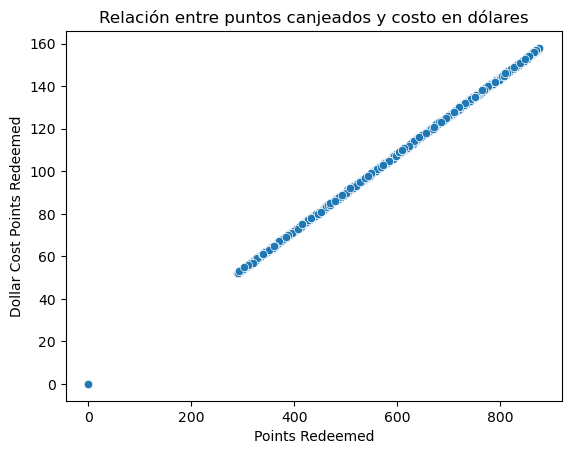

In [74]:
sns.scatterplot(data=flight, x='Points Redeemed', y='Dollar Cost Points Redeemed')
plt.title("Relación entre puntos canjeados y costo en dólares")
plt.show()

In [75]:
flight["Points Redeemed"].sum()/flight["Dollar Cost Points Redeemed"].sum()

5.554674876967415

In [76]:
# El numero total de filas - los datos no nulos del resto de niveles educativos = datos nulos de salario
customers.shape[0] - customers.Salary.count() == customers["Salary"].isnull().sum()

True

In [77]:
customers["Salary"] = customers["Salary"].fillna(0)

<Axes: xlabel='Salary', ylabel='Count'>

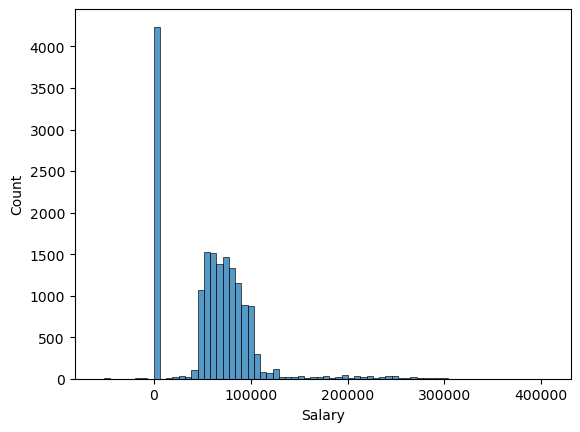

In [78]:
sns.histplot(data = customers, x = "Salary")

In [79]:
# Convertir los valores negativos en la columna 'Salary' a positivos
customers['Salary'] = customers['Salary'].abs()

### Generamos columnas necesarias y ajustamos formatos

#### Columnas de fechas

In [82]:
customers.dtypes

Loyalty Number          int64
Country                object
Province               object
City                   object
Postal Code            object
Gender                 object
Education              object
Salary                float64
Marital Status         object
Loyalty Card           object
CLV                   float64
Enrollment Type        object
Enrollment Year         int64
Enrollment Month        int64
Cancellation Year     float64
Cancellation Month    float64
dtype: object

Los datos de mes y año de cancelación están en formato float (con decimales), por lo que no se reconocen correctamente en la fórmula y tenemos que pasarlo a integer para que funcione.

In [84]:
# Crear 'Enrollment Date' con formato específico
customers['Enrollment Date'] = pd.to_datetime(
    customers['Enrollment Year'].astype('Int64').astype(str) + '-' + 
    customers['Enrollment Month'].astype('Int64').astype(str) + '-01',
    format="%Y-%m-%d", 
    errors='coerce'
)

In [85]:
# Crear 'Cancellation Date' solo si existen valores válidos en ambas columnas
customers['Cancellation Date'] = np.where(
    (customers['Cancellation Year'].notna()) & (customers['Cancellation Month'].notna()),
    pd.to_datetime(
        customers['Cancellation Year'].astype('Int64').astype(str) + '-' +
        customers['Cancellation Month'].astype('Int64').astype(str) + '-01',
        format='%Y-%m-%d', errors='coerce'
    ),
    pd.NaT
)
# Asegurarse de que 'Cancellation Date' sea de tipo datetime
customers['Cancellation Date'] = pd.to_datetime(customers['Cancellation Date'], errors='coerce')

In [86]:
# Calcular los días en el programa, usando la fecha actual si 'Cancellation Date' es NaT
customers['Days in Membership'] = (
    customers['Cancellation Date'].fillna(pd.Timestamp.now()) - customers['Enrollment Date']
).dt.days

In [87]:
customers.head(3)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,Days in Membership
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN,2016-02-01,NaT,3230
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,0.0,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN,2016-03-01,NaT,3201
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,0.0,Single,Star,3839.75,Standard,2014,7,2018.0,1.0,2014-07-01,2018-01-01,1280


#### Columna para churn

In [89]:
customers["churn"] = np.where(customers['Cancellation Year'].isna(), 0, 1)

In [90]:
customers['churn']

0        0
1        0
2        1
3        0
4        0
        ..
16732    0
16733    0
16734    0
16735    0
16736    1
Name: churn, Length: 16737, dtype: int32

### Uniformidad de los datos

In [92]:
customers['Enrollment Type'].replace({
    'Standard': 'Regular Enrollment',
    '2018 Promotion': 'Promotional Campaign 2018'
}, inplace=True)

C:\Users\lmtin\AppData\Local\Temp\ipykernel_16612\2355157903.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['Enrollment Type'].replace({


### Eliminamos columnas no necesarias
Eliminamos el país porque todos los datos pertenecen a Canadá

In [94]:
customers.Country.unique()

array(['Canada'], dtype=object)

In [95]:
customers.drop(columns = "Country", inplace= True)

## Tabla Flight
En la tabla tenemos una fila por cada mes para cada cliente con informacion de cuantos vuelos hizo en ese mes, la distancia que recorrió y los puntos que acumuló en total en ese mes. Acumulan 1 punto por cada km de distancia recorrido.

### Generamos columnas necesarias

In [132]:
flight['Puntos sin Canjear'] = flight['Points Accumulated'] - flight['Points Redeemed']

In [133]:
flight['Coste en Dólares de Puntos sin Canjear'] = (flight['Puntos sin Canjear'] * (flight['Dollar Cost Points Redeemed'] / flight['Points Redeemed'])).round(2)

In [141]:
flight.columns

Index(['Loyalty Number', 'Year', 'Month', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed',
       'Flight Date', 'Puntos sin Canjear',
       'Coste en Dólares de Puntos sin Canjear'],
      dtype='object')

# Unión de las dos tablas

In [286]:
flight_resumen = flight.groupby(["Loyalty Number"]).agg({
    "Total Flights":"sum",
    "Distance":"sum",
    "Points Accumulated":"sum",
    "Points Redeemed":"sum",
    "Dollar Cost Points Redeemed":"sum",
    'Puntos sin Canjear': "sum",
    'Coste en Dólares de Puntos sin Canjear':"sum"
}).reset_index()

data_1 = pd.merge(customers, flight_resumen, on = "Loyalty Number",  how = "left")
data_1.head()

,Loyalty Number,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,...,Cancellation Date,Days in Membership,churn,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Puntos sin Canjear,Coste en Dólares de Puntos sin Canjear
0,480934,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,...,NaT,3230,0,37,54525,54525.0,1418,256,53107.0,1343.08
1,549612,Alberta,Edmonton,T3G 6Y6,Male,College,0.0,Divorced,Star,3839.61,...,NaT,3201,0,58,77487,77487.0,1971,356,75516.0,3428.10
2,429460,British Columbia,Vancouver,V6E 3D9,Male,College,0.0,Single,Star,3839.75,...,2018-01-01,1280,1,18,24803,24803.0,374,67,24429.0,179.86
3,608370,Ontario,Toronto,P1W 1K4,Male,College,0.0,Single,Star,3839.75,...,NaT,4325,0,35,48432,48432.0,1291,233,47141.0,328.24
4,530508,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,...,NaT,3718,0,37,55515,55515.0,0,0,55515.0,0.00


In [287]:
data_1.shape

(16737, 26)

# CLUSTERING - KMeans + PCA 
## Preparación de los datos para el modelo

In [289]:
data_1 = data_1.drop(columns=[
    'Loyalty Number', 'Province', 'Postal Code', 
    'Enrollment Type', 'Enrollment Year', 'Enrollment Month', 'Cancellation Year',
    'Cancellation Month', 'churn', 'Enrollment Date', 'Year', 'Month', "vuelos_persona", "City", "Cancellation Date"
]
, errors='ignore')

In [290]:
data_dummies = pd.get_dummies(data_1, columns=['Gender', 'Education', 'Marital Status', 'Loyalty Card'], drop_first=True)
data_1.head()

,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Days in Membership,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Puntos sin Canjear,Coste en Dólares de Puntos sin Canjear
0,Female,Bachelor,83236.0,Married,Star,3839.14,3230,37,54525,54525.0,1418,256,53107.0,1343.08
1,Male,College,0.0,Divorced,Star,3839.61,3201,58,77487,77487.0,1971,356,75516.0,3428.10
2,Male,College,0.0,Single,Star,3839.75,1280,18,24803,24803.0,374,67,24429.0,179.86
3,Male,College,0.0,Single,Star,3839.75,4325,35,48432,48432.0,1291,233,47141.0,328.24
4,Male,Bachelor,103495.0,Married,Star,3842.79,3718,37,55515,55515.0,0,0,55515.0,0.00


### Matriz de correlación

In [292]:
correlaciones = data_dummies.corr() 
# Aplicar un filtro para mostrar solo las correlaciones mayores a 0.8 o menores a -0.8
filtro_correlacion_fuerte = correlaciones[(correlaciones > 0.8) | (correlaciones < -0.8)]

# Mostrar la matriz de correlaciones filtrada
filtro_correlacion_fuerte

,Salary,CLV,Days in Membership,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Puntos sin Canjear,Coste en Dólares de Puntos sin Canjear,Gender_Male,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single,Loyalty Card_Nova,Loyalty Card_Star
Salary,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLV,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days in Membership,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Flights,NaN,NaN,NaN,1.000000,0.967950,0.928546,NaN,NaN,0.925331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,NaN,NaN,NaN,0.967950,1.000000,0.959935,NaN,NaN,0.957280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Points Accumulated,NaN,NaN,NaN,0.928546,0.959935,1.000000,NaN,NaN,0.999749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Points Redeemed,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.999996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dollar Cost Points Redeemed,NaN,NaN,NaN,NaN,NaN,NaN,0.999996,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Puntos sin Canjear,NaN,NaN,NaN,0.925331,0.957280,0.999749,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coste en Dólares de Puntos sin Canjear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
# Eliminamos columnas muy relacionadas
data_dummies = data_dummies.drop(columns=["Coste en Dólares de Puntos sin Canjear", "Distance", "Points Redeemed", "Points Accumulated"])

## Estandarización de los datos

In [295]:
# Crear el objeto StandardScaler
scaler = StandardScaler()

# Aplicar el escalado a los datos y convertir el resultado a un DataFrame
data_estandar = scaler.fit_transform(data_dummies)
data_estandar = pd.DataFrame(data_estandar, columns=data_dummies.columns)

# Ver las primeras filas de los datos estandarizados
data_estandar.head()

,Salary,CLV,Days in Membership,Total Flights,Dollar Cost Points Redeemed,Puntos sin Canjear,Gender_Male,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single,Loyalty Card_Nova,Loyalty Card_Star
0,0.524021,-0.604852,0.191413,0.391330,0.958851,0.207228,-0.995053,-0.582295,-0.214164,-0.221388,-0.176924,0.848092,-0.604939,-0.715871,1.091589
1,-1.295542,-0.604784,0.166867,1.636509,1.734049,0.950250,1.004971,1.717343,-0.214164,-0.221388,-0.176924,-1.179117,-0.604939,-0.715871,1.091589
2,-1.295542,-0.604763,-1.459083,-0.735260,-0.506273,-0.743658,1.004971,1.717343,-0.214164,-0.221388,-0.176924,-1.179117,1.653059,-0.715871,1.091589
3,-1.295542,-0.604763,1.118230,0.272742,0.780555,0.009411,1.004971,1.717343,-0.214164,-0.221388,-0.176924,-1.179117,1.653059,-0.715871,1.091589
4,0.966888,-0.604320,0.604460,0.391330,-1.025656,0.287071,1.004971,-0.582295,-0.214164,-0.221388,-0.176924,0.848092,-0.604939,-0.715871,1.091589


## Modelo - PCA

In [297]:
modelo = PCA(n_components= 15)
tabla_cluster_pca = modelo.fit_transform(data_estandar)

tabla_cluster_pca_df = pd.DataFrame(tabla_cluster_pca, columns=[f"PC{i}" for i in range (1, 16)])
# Mostrar las primeras filas del DataFrame
tabla_cluster_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0.575900,1.091168,-1.367901,-0.690958,0.074289,-0.084025,-0.954311,0.701201,-0.504198,-0.444433,0.438592,0.210300,-0.200204,0.142630,-0.050853
1,2.584447,-1.518407,-1.113591,-0.670931,-0.635310,-0.488791,0.017234,-0.840135,-0.502771,0.728257,1.060391,0.242494,1.415447,0.168136,-0.428806
2,-1.048519,-3.309931,-1.097269,0.350827,-0.510526,-0.122728,0.157899,-0.969357,0.260937,0.351653,0.720551,0.157855,-0.221988,0.087709,-0.142075
3,1.551138,-2.779693,-1.148481,0.356147,-0.559836,-0.145725,0.144041,-0.924870,-0.863488,0.165678,-0.508923,0.131678,-0.219330,0.061585,0.008253
4,0.030973,1.209588,-1.420777,-0.590517,-0.334402,-0.360635,0.114604,-0.998485,0.903021,-0.564747,-0.830940,0.186246,-0.223966,0.462598,-0.101844


In [271]:
modelo.explained_variance_ratio_.cumsum()

array([0.17728153, 0.34002017, 0.45984037, 0.5587131 , 0.63359043,
       0.70665189, 0.77800986, 0.84903123, 0.89813272, 0.94528065,
       0.96842595, 0.98798776, 0.99569003, 1.        ])

In [306]:
# Seleccionamos las columnas que explican el 80% de la varianza
data_clean =tabla_cluster_pca_df.drop(columns=["PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15"])

## KMeans

In [320]:
acum = []    #hago un bucle para poder ver los errores según el tipo de clusters
for i in range(1,13):
    model = KMeans(
        n_clusters=i, # número de centroides
        n_init = 10, # número de semillas diferentes que va a probar el algoritmo
        max_iter = 300 # número de iteraciones que va a hacer hasta encontrar el óptimo en cada semilla
    )
    model.fit(data_clean)
    acum.append([i,model.inertia_])

<Axes: xlabel='clusters', ylabel='Error'>

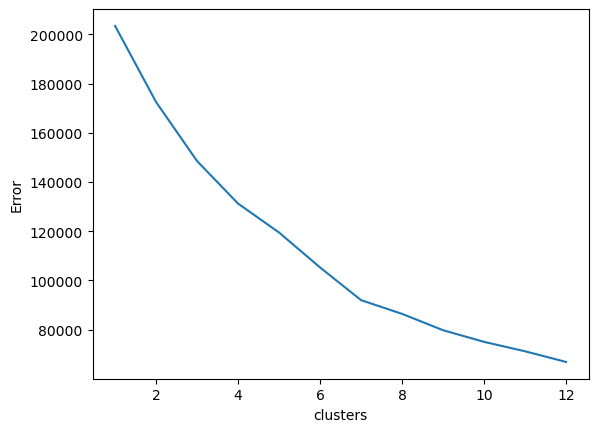

In [323]:
tabla_codo = pd.DataFrame(
    acum,
    columns =["clusters", "Error"]
)
sns.lineplot(data = tabla_codo, 
             x = "clusters", 
             y = "Error"
            )

### Seleccionamos 4 clusters

In [331]:
modelo = KMeans(
    n_clusters = 4, #número de centroides (o semillas en cada iteración)
    n_init = 10,  # cuantas veces distintas voy a tirar 5 puntos rojos
    max_iter = 300  #entre 100 y 300, cauntas veces itero por cada tirada de 5 semillas
    
)
modelo.fit(data_clean)

KMeans(n_clusters=4, n_init=10)

In [347]:
data_dummies["cluster"] = modelo.labels_

In [336]:
data_1["cluster"] = modelo.labels_
data_1.head()

,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Days in Membership,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Puntos sin Canjear,Coste en Dólares de Puntos sin Canjear,cluster
0,Female,Bachelor,83236.0,Married,Star,3839.14,3230,37,54525,54525.0,1418,256,53107.0,1343.08,1
1,Male,College,0.0,Divorced,Star,3839.61,3201,58,77487,77487.0,1971,356,75516.0,3428.10,3
2,Male,College,0.0,Single,Star,3839.75,1280,18,24803,24803.0,374,67,24429.0,179.86,3
3,Male,College,0.0,Single,Star,3839.75,4325,35,48432,48432.0,1291,233,47141.0,328.24,3
4,Male,Bachelor,103495.0,Married,Star,3842.79,3718,37,55515,55515.0,0,0,55515.0,0.00,1


## Análisis de resultados

In [349]:
data_dummies.groupby("cluster").mean()

,Salary,CLV,Days in Membership,Total Flights,Dollar Cost Points Redeemed,Puntos sin Canjear,Gender_Male,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single,Loyalty Card_Nova,Loyalty Card_Star
cluster,,,,,,,,,,,,,,,
0,103757.848425,7440.624902,2998.860236,30.659449,133.454724,47089.355315,0.474409,0.000000,0.000000,0.000000,1.0,0.409449,0.212598,0.297244,0.547244
1,80321.893817,8168.818005,3472.200134,38.669758,170.541129,59792.775806,0.498118,0.000403,0.075538,0.065457,0.0,0.805914,0.009543,0.346371,0.436559
2,63084.863777,8207.156179,1648.958204,6.900155,25.507224,10241.686146,0.493550,0.180599,0.044118,0.049794,0.0,0.640093,0.192982,0.360681,0.431889
3,19762.180541,7600.932335,3364.040098,36.390189,158.552208,56131.080908,0.502137,0.719520,0.000204,0.020761,0.0,0.213719,0.723998,0.314472,0.496031


# REGRESIÓN LOGÍSTICA

## Preparación de datos para el modelo

In [63]:
data_ML = data_1.copy()

In [64]:
# Eliminamos columnas de fechas, multicolineales y no relevantes para el modelo
data_ML.drop(columns = ['Province', 'City', 'Postal Code','Enrollment Year', 'Enrollment Month',
       'Cancellation Year', 'Cancellation Month','Enrollment Date',
       'Cancellation Date', "Dollar Cost Points Redeemed", "Distance", "Loyalty Number"], inplace= True)

In [65]:
data_ML.columns

Index(['Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card',
       'CLV', 'Enrollment Type', 'Days in Membership', 'churn',
       'Total Flights', 'Points Accumulated', 'Points Redeemed'],
      dtype='object')

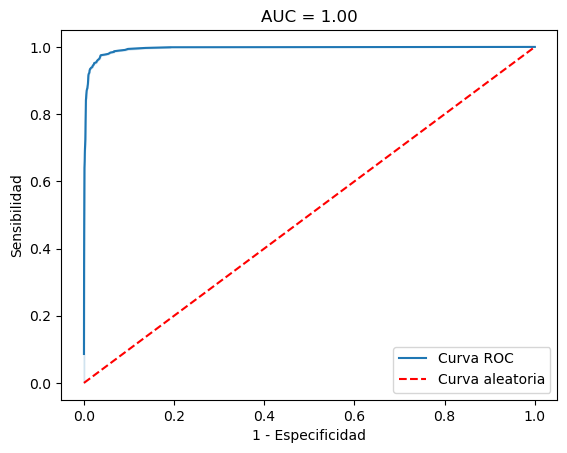

Accuracy: 0.9654
Sensibilidad: 0.7377
Especificidad: 0.9967
AUC: 0.9953


In [66]:
X = data_ML.drop(columns="churn")
y = data_ML["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.75,
    test_size=0.25
)

# Convierte las variables categóricas a variables dummy en ambos conjuntos de datos
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinea las columnas de X_train y X_test para que coincidan
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Escalar X_train y X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Generamos el modelo de regresión logística
lr = LogisticRegression(max_iter=2000000, solver='liblinear') # Solver porque tenemos pocos datos

# Aplica RFE para la selección de características
rfe = RFE(lr, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Ajuste del modelo usando las características seleccionadas
lr.fit(X_train_scaled[:, rfe.support_], y_train)

# Filtrado de las características seleccionadas por RFE
filtro = rfe.support_

# Selección de las columnas correspondientes en X_train y X_test
X_train_final = X_train.loc[:, filtro]
X_test_final = X_test.loc[:, filtro]

# Entrenamiento del modelo con las características seleccionadas
lr.fit(X_train_final, y_train)

# Predicción sobre el conjunto de prueba
y_pred = lr.predict(X_test_final)

# Predicción de probabilidades para la curva ROC
y_pred_proba = lr.predict_proba(X_test_final)[:, 1]

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
TN = matriz_confusion[0][0]
TP = matriz_confusion[1][1]
FN = matriz_confusion[1][0]
FP = matriz_confusion[0][1]

# Accuracy
accuracy = (TN + TP) / (TN + TP + FN + FP)

# Sensibilidad (Recall) para churn = 1
sensibilidad = TP / (TP + FN)

# Especificidad para churn = 0
especificidad = TN / (TN + FP)

# Curva ROC
especificidad_inv, sensibilidad_roc, threshold = roc_curve(y_test, y_pred_proba)

# Línea diagonal de la curva ROC (y = x)
recta_x = [i * 0.01 for i in range(101)]
recta_y = recta_x

# Graficar la curva ROC
sns.lineplot(x = especificidad_inv, y = sensibilidad_roc, label='Curva ROC')
sns.lineplot(x = recta_x, y = recta_y, ls="--", c="r", label='Curva aleatoria')

# AUC (Área bajo la curva ROC)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Mostrar la AUC
plt.title(f'AUC = {roc_auc:.2f}')
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.legend()
plt.show()

# Resultados finales
print(f'Accuracy: {accuracy:.4f}')
print(f'Sensibilidad: {sensibilidad:.4f}')
print(f'Especificidad: {especificidad:.4f}')
print(f'AUC: {roc_auc:.4f}')

In [67]:
flight.Year.value_counts()

Year
2018    201836
2017    191100
Name: count, dtype: int64

# MODELO RANDOM FOREST
## Sin PCA

In [69]:
X = data_ML.drop(columns="churn")
y = data_ML["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.75,
    test_size=0.25
)

# Convierte las variables categóricas a variables dummy en ambos conjuntos de datos
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

rf_clf = RandomForestClassifier(max_depth=3, n_estimators = 20, min_samples_split=10, class_weight='balanced')
rf_clf.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)
accuracy_rf = np.mean(y_pred_adjusted == y_test)

print(f'Accuracy del Random Forest sin PCA: {accuracy_rf}')

Accuracy del Random Forest sin PCA: 1.0


In [70]:
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3690
           1       1.00      1.00      1.00       495

    accuracy                           1.00      4185
   macro avg       1.00      1.00      1.00      4185
weighted avg       1.00      1.00      1.00      4185



## Con PCA
El modelo presenta un desbalance entre las clases `churn = 0` (mayoría) y `churn = 1` (minoría), lo que podría afectar su rendimiento. Sin embargo, a pesar de una accuracy alta de `0.98`, es crucial analizar otras métricas para evaluar su desempeño. El recall para `churn = 1` es de `0.87`, lo que indica que el modelo está identificando bien a los casos positivos, pero con algunos falsos negativos. El f1-score para `churn = 1` es de `0.93`, lo que refleja un buen equilibrio entre precisión y recall para la clase minoritaria.

La validación cruzada arrojó una accuracy media de `0.97`, lo que sugiere que el modelo es consistente en diferentes particiones de los datos. Además, el AUC de `0.94` confirma que el modelo tiene una excelente capacidad de discriminar entre las dos clases, sin sobreajuste, a pesar de los altos valores de precisión.

En resumen, aunque la accuracy es alta, las métricas adicionales indican que el modelo está realizando predicciones equilibradas y efectivas, especialmente en la clase `churn = 1`.

In [76]:
X = pd.get_dummies(data_ML, drop_first=True)

scaler = StandardScaler()
X_standar = scaler.fit_transform(X)

modelo = PCA(n_components=17) # Nº de columnas
X_pca = modelo.fit_transform(X_standar)

X_standar = pd.DataFrame(
    X_pca,
    columns = [f"PC{i}" for i in range (1, 18)]
)

modelo.explained_variance_ratio_.cumsum()
# Nos quedamos con todas hasta PC9, varianza 0.82

array([0.17865767, 0.32459803, 0.42343858, 0.50823774, 0.58943806,
       0.65109857, 0.71126425, 0.77003101, 0.82854741, 0.87841699,
       0.91876308, 0.94686022, 0.96591778, 0.98200989, 0.99141857,
       0.99775521, 1.        ])

In [78]:
data_clean = X_standar.iloc[:,0:9]

In [80]:
# Definir X con las columnas principales en data_clean
X = data_clean

# Definir y como la columna objetivo; reemplaza "churn" por el nombre de tu variable objetivo
y = data_ML["churn"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

# Entrenar el modelo
rf_clf = RandomForestClassifier(max_depth=3, n_estimators = 20, min_samples_split=10, class_weight='balanced')
rf_clf.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba > 0.6).astype(int)
accuracy_rf = np.mean(y_pred_adjusted == y_test)

print(f'Accuracy del Random Forest con PCA: {accuracy_rf}')

Accuracy del Random Forest con PCA: 0.9909199522102748


In [82]:
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3686
           1       0.97      0.95      0.96       499

    accuracy                           0.99      4185
   macro avg       0.98      0.97      0.98      4185
weighted avg       0.99      0.99      0.99      4185



In [84]:
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_adjusted)
print(f'AUC: {auc}')

AUC: 0.9740528262167308
